In [1]:
import numpy 
from sklearn.neural_network import MLPRegressor 
from glob import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import pandas as pd

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n)]      
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
def toOrigin (dataArr):
    dataO = []
    shiftArr = []
    for path in np.array(dataArr):
        pathO = []
        shifter = path[0]
        shiftArr.append(shifter)
        for coord in range(len(path)):
            shifted = path[coord] - shifter
            pathO.append(shifted)
        dataO.append(pathO)
    return dataO, shiftArr


# def toOrigin(dataArr):
#     shiftArr = []
#     for path in np.array(dataArr):
#         shifter = path[0]
#         shiftArr.append(shifter)
#     return shiftArr
        
# # intialize a dataset
# city = 'dearborn' 
# split = 'train'

# # get train data
# inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
# all_in_1 = []
# for i in range(len(inputs)):
#     togetherData = np.concatenate((inputs[i], outputs[i]))
#     all_in_1.append(togetherData)
    
# train_dataset  = ArgoverseDataset(city = city, split = split)

In [3]:
import math
    
#   rotate the x,y with angle (as vector)
# returns rotated x,y
def rotatePoint(x, y, rad):
    xR = x*math.cos(rad) - y*math.sin(rad)
    yR = y*math.cos(rad) + x*math.sin(rad)
    return xR, yR

# num_iteration determines how deep the relationship we are calculating
# ex: num_iteration = 1, we add speed
# ex: num_iteration = 2, we add speed + acceleration
# ex: num_iteration = 3, we add speed + acceleration + accel-acceleration
def relation(l, num_iteration):
    length = len(l)
    # each loop adds one set of further relationship data
    for loop in range(num_iteration):
        xv = [ l[i] for i in range(len(l) - (length - 2*(loop)), len(l)) if i % 2 == 0 ]
        yv = [ l[i] for i in range(len(l) - (length - 2*(loop)), len(l)) if i % 2 == 1 ]
        xa = (np.array(xv[1:]) - np.array(xv[0:-1]))*10
        ya = (np.array(yv[1:]) - np.array(yv[0:-1]))*10
        l = list(l) + list(xa)
        l = list(l) + list(ya)
    return l

# rotate the paths in the data to initialize to the same direction
# takes in the data and logArr for converting result back (logArr should contain the shift value)
# returns rotated datapath, new logarr with angles corresponding to each path to rotate back (construct original long/lat)
def rotateData(data, logArr):
#     logArr should have same lenth with data, since each path is shifted to (0,0)
    newLogArr = []
    dataR = []
    for i,path in enumerate(data):
        pathR = []
        ang = getAngle(path)
        newLogArr.append(np.concatenate((logArr[i], [ang])))
#         for each point, rotate them to math the orientation(except (0,0))
        pathR.append(path[0])
        for j in range(1, len(path)):
            xp = path[j][0]
            yp = path[j][1]
#             get rotated point
            xR, yR = rotatePoint(xp, yp, ang)
            pathR.append([xR,yR])
        dataR.append(pathR)
    return dataR, newLogArr


# shift & rotate data, takes in a raw data array (arbitrary length of paths, but each path has (x,y) points)
# returns processed data (without velocity added, but shifted to origin & rotated)
def shiftAndRotate(data):
#     shift data, get shifted array & shifted values for converting back
    data_O, shiftLog = toOrigin(data)
#     get rotated data & logs for converting back
    data_RO, logArr = rotateData(data_O, shiftLog)
#     print(logArr)
    return np.array(data_RO), logArr

# gets the angle to rotate to pointing (1,1) in radians
# the path needs to be shifted to (0,0) in the beginning
# path should only have (x,y), i.e. without velocity
def getAngle(path):
#     shifted path starts at (0,0), so path[1] is its initial facing direction
    direction = path[1]
#     target direction
    targetVec = np.array([1,1])
    x1 = path[1][0]
    x2 = 1
    y1 = path[1][1]
    y2 = 1
        #     magnitude of direction vector for angle calculation, sqrt(2) is targetVec's magnitude
    dot = x1*x2 + y1*y2      # dot product
    det = x1*y2 - y1*x2      # determinant
    angle = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    return angle

# shifter: [x,y]
def convBack(flatPath, shifter):
    for i in range(0, len(flatPath), 2):
        #  negative radiant to convert back
        xR, yR = rotatePoint(flatPath[i], flatPath[i+1], -1 * shifter[2])
        flatPath[i] = xR + shifter[0]
        flatPath[i+1] = yR + shifter[1]
    return flatPath
    

In [4]:
# # # get all the prediction 
# # final =[]
# # for city in cities:
# #     x = get_csv(city)
# #     for ele in x:
# #         final.append(ele)
# def get_csv(city):
    
#     # normalize data range -80~80
#     scalar = 80
    
#     # get train data  
#     inputs, outputs = get_city_trajectories(city=city, split="train", normalized=False)
#     train_in_1 = []
#     for i in range(len(inputs)):
#         togetherData = np.concatenate((inputs[i], outputs[i]))
#         train_in_1.append(togetherData)
        
#     #shift & rotate
#     # n*110*2     
#     processed, logArr = shiftAndRotate(train_in_1)
        
    
#     # in_put = n*100     , out_put = n*120
#     in_put = []
#     out_put = []
#     xFac = []
#     yFac = []
#     for path in processed:
        
#         flattenedX = (np.array(path).flatten())[::2]
#         flattenedY = (np.array(path).flatten())[1::2]
#         xMax = max(abs(flattenedX))
#         yMax = max(abs(flattenedY))
#         xScale = xMax/scalar
#         yScale = yMax/scalar
#         xFac.append(xScale)
#         yFac.append(yScale)
        
#         normedX = flattenedX / xScale
#         normedY = flattenedY / yScale
        
#         normPath = []
        
#         for i, pt in enumerate(normedX):
#             normPath.append(normedX[i])
#             normPath.append(normedY[i])
        
#         in_put.append(np.array(normPath[:50]).flatten())
#         out_put.append(np.array(normPath[50:]).flatten())

    
    
# #     =================================
# #     # get train data
# #     inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
# #     shiftArr = getShift(inputs)
    
# #     #get data ready for this city
# #     train_dataset = ArgoverseDataset(city, split = "train")
    
    
# #     output = [(np.array(d[1]) - np.array(shiftArr[i])).flatten() for i,d in enumerate(train_dataset)]
# #     in_put = [(np.array(d[0]) - np.array(shiftArr[i])).flatten() for i,d in enumerate(train_dataset)]


#     in_put_New = [ relation(l,3) for l in in_put ]
    
    
#     #train the model for this city
#     model = MLPRegressor(activation="relu", solver="adam", early_stopping=True, validation_fraction = 0.3,
#     learning_rate="adaptive", max_iter=400,alpha=0.001,hidden_layer_sizes = (32,64,64,128))
    
#     model.fit(in_put_New,out_put)
    
    
# #     get the predictoin 
#     test_input, nan = get_city_trajectories(city, "test", normalized=False)
#     processedTest , testShifter = shiftAndRotate(test_input)
    
#     # in_put = n*100     , out_put = n*120
#     in_put = []
#     xFac = []
#     yFac = []
#     for path in processedTest:
        
#         flattenedX = (np.array(path).flatten())[::2]
#         flattenedY = (np.array(path).flatten())[1::2]
#         xMax = max(abs(flattenedX))
#         yMax = max(abs(flattenedY))
#         xScale = xMax/scalar
#         yScale = yMax/scalar
#         xFac.append(xScale)
#         yFac.append(yScale)
        
#         normedX = flattenedX / xScale
#         normedY = flattenedY / yScale
        
#         in_put_Test = []
        
#         for i, pt in enumerate(normedX):
#             in_put_Test.append(normedX[i])
#             in_put_Test.append(normedY[i])
            
#         in_put.append(np.array(in_put_Test).flatten())
        
    
# #     testShifter = getShift(test_input)

#     x = in_put
#     print(np.array(x).shape)
#     x_New = [ relation(l,3) for l in x ]
#     y = model.predict(x_New)
#     yBack = []
#     backPath = []
#     for i, path in enumerate(y):
#         pathX = np.array(path[::2])
#         pathY = np.array(path[1::2])
        
#         pathX = pathX * xFac[i]
#         pathY = pathY * yFac[i]
        
#         for j, pt in enumerate(pathX):
#             backPath.append(pathX[j])
#             backPath.append(pathY[j])        
        
        
#         yBack.append(convBack(backPath, testShifter[i]))
#     print(model.loss_)
    
#     return yBack



In [5]:
# # get all the prediction 
# final =[]
# for city in cities:
#     x = get_csv(city)
#     for ele in x:
#         final.append(ele)
def get_csv(city):
    
    # normalize data range -80~80
    scalar = 80
    
    # get train data  
    inputs, outputs = get_city_trajectories(city=city, split="train", normalized=False)
    train_in_1 = []
    for i in range(len(inputs)):
        togetherData = np.concatenate((inputs[i], outputs[i]))
        train_in_1.append(togetherData)
        
    #shift & rotate
    # n*110*2     
    processed, logArr = shiftAndRotate(train_in_1)
        
    
    # in_put = n*100     , out_put = n*120
    in_put = []
    out_put = []
    for path in processed:
            
        in_put.append(np.array(path[:50]).flatten())
        out_put.append(np.array(path[50:]).flatten())
    
    
    
#     =================================
#     # get train data
#     inputs, outputs = get_city_trajectories(city=city, split=split, normalized=False)
#     shiftArr = getShift(inputs)
    
#     #get data ready for this city
#     train_dataset = ArgoverseDataset(city, split = "train")
    
    
#     output = [(np.array(d[1]) - np.array(shiftArr[i])).flatten() for i,d in enumerate(train_dataset)]
#     in_put = [(np.array(d[0]) - np.array(shiftArr[i])).flatten() for i,d in enumerate(train_dataset)]
    in_put_New = [ relation(l,3) for l in in_put ]
    
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=True, validation_fraction = 0.3,
    learning_rate="adaptive", max_iter=400,alpha=0.001,hidden_layer_sizes = (32,64,64,128))
    
    model.fit(in_put_New,out_put)
    
    
#     get the predictoin 
    test_input, nan = get_city_trajectories(city, "test", normalized=False)
    processedTest , testShifter = shiftAndRotate(test_input)
#     testShifter = getShift(test_input)

    in_put_Test = []
    
    for path in processedTest:
#         print(path.shape)
        in_put_Test.append(np.array(path).flatten())

    x = in_put_Test
    x_New = [ relation(l,3) for l in x ]
#     print(np.array(x_New).shape)
    y = model.predict(x_New)
    yBack = []
    for i, path in enumerate(y):
        yBack.append(convBack(path, testShifter[i]))
    print(model.loss_)
    
    return yBack



In [6]:
# 1*4*2
test = [[[-1,-1], [-2,-2], [-3,-5], [-4, -5]]]
xMax = np.amax(abs(np.array(test[:][0])))
print(xMax)

a = [1,2,3,4]
print(a[::2])

5
[1, 3]


In [7]:
# prev best: validation_fraction = 0.3, learning_rate="adaptive", max_iter=400,alpha=0.001, l2
y = get_csv('dearborn')

7.774761934270787


In [8]:
print(y[0])

[9328.94936072 3278.05107959 9328.36440774 3278.08725135 9326.80020537
 3277.76625756 9325.57876529 3278.02366319 9324.52074965 3277.36790015
 9323.77254465 3277.57151451 9322.17022083 3277.5295477  9320.8459437
 3277.43838836 9319.86314457 3277.73479706 9319.11531708 3277.52339423
 9317.95771639 3277.23522666 9316.32340291 3277.23832378 9315.55281359
 3276.96861844 9314.25379027 3277.07036235 9313.18449924 3277.10805747
 9312.16609397 3277.01230198 9310.79506085 3276.98636403 9310.07854883
 3277.17534803 9308.77386426 3276.89488663 9307.82906248 3277.09415039
 9306.57099323 3276.5452298  9305.37365253 3276.60479877 9304.1862985
 3276.28011477 9303.33733052 3276.73250528 9302.30028746 3276.4176259
 9301.24605778 3276.62105637 9300.18026882 3276.84989554 9298.70220621
 3276.22007275 9297.94332694 3276.57475657 9296.74663406 3276.40032772
 9295.87786274 3276.30260082 9294.50385596 3276.40871255 9293.54655859
 3275.66929218 9292.46593082 3276.12001061 9291.42967301 3276.02529539
 9290.149

In [243]:
'''
7.872267641615865
6.871840259436851
7.391471655959644
8.694680777915867
8.32759640295571
9.152925434241014
'''
final_test = []
for city in cities:
    x = get_csv(city)
    for ele in x:
        final_test.append(ele)

7.975880223993704
6.7612880566393425
7.024743283230947
8.258660609148263
7.720973771460657
7.84411920789905


In [10]:
# get all the prediction 
final =[]
for city in cities:
    x = get_csv(city)
    for ele in x:
        final.append(ele)

7.805424868861947
6.6583796320696775
6.897450642442772
8.836251716154878
7.701295564343794
8.31980185243284


In [11]:
print(len(final))

29843


In [248]:
np.savetxt("prediction.csv", 
           final_test,
           delimiter =", ", 
           fmt ='% s')

In [234]:
df = pd.read_csv('C:/Users/ly264/Desktop/CSE151b_final_project/sample_submission.csv')

In [12]:
final

[array([ -12.93990256, -567.01775478,  -13.71026141, -566.73748361,
         -14.51184475, -566.60860964,  -15.4174932 , -566.10482703,
         -16.10272871, -566.1063004 ,  -16.60855912, -565.98044345,
         -17.59903716, -565.640545  ,  -18.3904161 , -565.20591712,
         -19.28250457, -565.07430057,  -20.20630707, -564.76699733,
         -20.6711681 , -564.58815608,  -21.303115  , -564.17725242,
         -22.38042214, -564.19972734,  -22.939621  , -564.02370772,
         -23.836144  , -563.59357271,  -24.47765843, -563.11073127,
         -25.39558827, -563.18916177,  -26.0843734 , -562.72874324,
         -26.81889074, -562.56278785,  -27.44184408, -562.37290484,
         -28.51920689, -562.03344161,  -29.27576155, -561.79543656,
         -30.09301997, -561.68942941,  -30.74245199, -561.01974323,
         -32.00764763, -560.99511654,  -32.4752293 , -560.74026646,
         -33.50348039, -560.32997342,  -34.00825083, -560.18856518,
         -34.8843    , -559.98323705,  -35.63036

<function matplotlib.pyplot.show(close=None, block=None)>

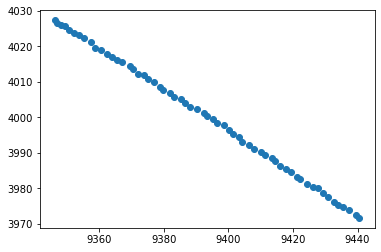

In [20]:
import matplotlib.pyplot as plt
y_show = y[677]
x_res = []
y_res = []
for i in range(0,120,2):
    x_res.append(y_show[i])
    y_res.append(y_show[i+1])
plt.scatter(x_res, y_res)
plt.show

In [249]:
    #get data ready for this city
    train_dataset = ArgoverseDataset("austin", split = "train")
    output = [d[1].flatten() for d in train_dataset]
    in_put = [d[0].flatten() for d in train_dataset]
    
    #train the model for this city
    model = MLPRegressor(activation="relu", solver="adam", early_stopping=False,
    learning_rate="adaptive", max_iter=400,alpha=0.001,hidden_layer_sizes = (32,64,64,128))
    
    model.fit(in_put,output)
    

    

MLPRegressor(alpha=0.001, hidden_layer_sizes=(32, 64, 64, 128),
             learning_rate='adaptive', max_iter=400)